Based on Elli/DeepQL-3.ipynb and RL_subpolytope.ipynb

In [1]:
!pip3 install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.5/406.5 kB 50.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 31.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 31.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.

In [242]:
import numpy as np

import random
from cytools import Polytope
from cytools import fetch_polytopes
from cytools import Polytope
from cytools import fetch_polytopes
from cytools.cone import Cone
from flint import fmpz_mat
from cytools.utils import gcd_list
from cytools.polytope import poly_v_to_h
# from cytools import polytope
from cytools.triangulation import Triangulation

from copy import deepcopy

from notebooks.integer_rref import i4mat_rref
import tensorflow as tf

tfk = tf.keras

In [294]:
from copy import deepcopy

class SubpolytopeEnvironment(object):
    def __init__(self, polytope, fibration_dim):
        self._p = polytope
        self._points = polytope.points()[1:]
        self._d = fibration_dim
        self._num_actions = fibration_dim

    def random_state(self):
        return np.random.choice(self._points.shape[0], size=(self._d))

    @staticmethod
    def reduce_polytope(vertices):
        vertices_copy = np.array(vertices, copy=True)
        W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
        local_vertices = np.round(vertices@np.linalg.pinv(W))
        idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))

        return np.delete(local_vertices, idx, axis=1)

    def intersect(self, state):
        vertices_basis = []
        for pt_id in state:
            vertices_basis.append(self._points[pt_id])

        vertices_basis = np.asarray(vertices_basis)
        vertices = []
        for pt in self._points:
            if np.linalg.matrix_rank(
                np.append(vertices_basis, [pt], axis=0)) == self._d:
                vertices.append(pt)
        return np.asarray(vertices)

    def R(self, state):
        vertices = self.intersect(state)

        reward = 0.0
        reward -= (np.linalg.matrix_rank(vertices) - self._d)**2

        if len(vertices.shape) < 2:
            reward -= 10.
        else:
            p_reduced = Polytope(np.asarray(self.reduce_polytope(vertices), np.int32))
            reward += (1.0 if p_reduced.is_reflexive() else -1.0)
            reward -= (p_reduced.dimension() - self._d)**2

        return reward, reward > 0

    def act(self, state, action):
        new_state = deepcopy(state)
        new_state[action] = ((new_state[action] + 1) % (self._points.shape[0]))

        return new_state#, self.R(new_state)

    @property
    def num_actions(self):
        return self._d

    @property
    def all_actions(self):
        return [i for i in range(self._d)]

In [345]:
def intersection(lst1, lst2):
    """ Input: two lists
        Output: the intersection of the two lists """
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def complement(lst1, lst2):
    """ Input: two lists
        Output: the complement of the two lists """
    lst3 = []
    for item in lst1:
        if not item in lst2:
            lst3.append(item)
    for item in lst2:
        if not item in lst1:
            lst3.append(item)

    return lst3


class FibrationTriangulationEnvironment(object):
    def __init__(self, polytope, fibration_dim):
        self._p = polytope
        self._2face_Ts = self.get_two_face_triangs(polytope)
        self._max_num_triangs = max(len(x) for x in self._2face_Ts)

        # Subpolytope Env
        self._s_env = SubpolytopeEnvironment(polytope, fibration_dim)


    def bits_to_simps(self, triang):
        """ Input: - bitlist describing triangulation of 2-faces
                   - list of all 2-face triangulations
            Output: the list of two simplices                    """
        two_face_triangs = self._2face_Ts
        two_simps = []
        for i in range(len(triang)):
            for j in range(len(triang[i])):
                if triang[i][j] == 1:
                    two_simps.append(two_face_triangs[i][j])

        return two_simps


    def act(self, state, action):
        new_state = deepcopy(state)

        if action[0] == 0:
            new_state[0][action[1]] = [0 for i in range(len(state[0][action[1]]))]
            new_state[0][action[1]][action[2]] = 1

        elif action[0] == 1:
            new_state[1] = self._s_env.act(state[1], action[1:])

        return new_state


    def get_actions(self):
        """
        Output: the list of all possible actions on the
                triangulation and line bundle sum
        """
        # [i,j]: choose the j-th triangulation of the i-th 2-face
        T_actions = []
        for i in range(len(self._2face_Ts)):
            for j in range(len(self._2face_Ts[i])):
                if len(self._2face_Ts[i]) > 1:
                    T_actions.append([0,i,j,0])

        # combine action lists
        action_list = T_actions + list(map(lambda x: [1,x], self._s_env.all_actions))

        return action_list


    def combine_triangulation(self, bitlist):
        """
        Input: the bitlist state
        Output: the combined triangulation
        """
        poly = self._p

        # get the list of facets
        facets = []
        for i in range(len(poly.facets())):
            facets.append(poly.points_to_labels(poly.facets()[i].points()))

        # get the list of 2-face simplices
        two_face_simps = [item for sublist in self.bits_to_simps(bitlist) for item in sublist]

        # combine the simplices from the 2-face triangulations
        simps = []
        for i in range(len(two_face_simps)):
            for j in range(i,len(two_face_simps)):
                if i!=j:
                    inters = intersection(two_face_simps[i], two_face_simps[j])
                    comp = complement(two_face_simps[i], two_face_simps[j])
                    if len(inters) == 2:
                        comp = complement(two_face_simps[i], two_face_simps[j])
                        for k in range(len((two_face_simps))):
                            if np.array([item in two_face_simps[k] for item in comp]).all():
                                simp = sorted(inters + comp)
                                for facet in facets:
                                    if np.array([item in facet for item in simp]).all():
                                        if not simp in simps:
                                            simps.append(simp)

        simps = [[0]+simp for simp in simps]

        return Triangulation(poly=poly, pts=poly._labels_not_facet, simplices=simps, check_input_simplices=False)


    def random_state(self):
        """
        Output: 3d bitlist state encoding the triangulation and line bundle sum
        """
        two_face_triangs = self._2face_Ts
        # determine the dimensions of the state bitlist
        dim1 = len(two_face_triangs)
        dim2 = self._max_num_triangs

        # randomly generate triangulation bitlist
        T = [[0 for j in range(dim2)] for i in range(dim1)]
        for i in range(len(two_face_triangs)):
            j = random.choice(range(len(two_face_triangs[i])))
            T[i][j] = 1

        # combine triangulation and subpolytope data
        state = [T, self._s_env.random_state()]

        return state


    def secondary_cone(self, two_face, simps):
        """
        Input: points, simplices and dimension
        Output: secondary cone of polytope
        """
        poly = self._p
        face = Polytope(two_face.points())

        two_pts_ext = [list(pt)+[1,] for pt in face.points(optimal=True)]
        pts_ext = [list(pt)+[1,] for pt in poly.points(optimal=True)]

        two_simps = [[face.points_to_labels(poly.points()[simp[i]]) for i in range(3)] for simp in simps]
        two_simps = [set(s) for s in two_simps]

        simps = [set(s) for s in simps]

        m = np.zeros((2+1, 2+2), dtype=int)
        null_vecs = set()
        for i in range(len(simps)):
            for j in range(len(simps[i+1:])):
                # define the simplices
                two_s1 = two_simps[i]
                two_s2 = two_simps[j]
                s1 = simps[i]
                s2 = simps[j]

                # eunsre that the simplices have a large enough intersection
                two_comm_pts = two_s1 & two_s2
                if len(two_comm_pts) != 2:
                    continue

                two_diff_pts = list(two_s1 ^ two_s2)
                two_comm_pts = list(two_comm_pts)
                for k,pt in enumerate(two_diff_pts):    m[:,k] = two_pts_ext[pt]
                for k,pt in enumerate(two_comm_pts):    m[:,k+2] = two_pts_ext[pt]

                # calculate nullspace/hyperplane inequality
                v = fmpz_mat(m.tolist()).nullspace()[0]
                v = np.array(v.transpose().tolist()[0], dtype=int)

                # ensure the sign is correct
                if v[0] < 0:
                    v *= -1

                # reduce the vector
                g = gcd_list(v)
                if g != 1:
                    v //= g

                # construct the full vector (including all points)
                full_v = np.zeros(len(pts_ext), dtype=int)

                diff_pts = list(s1 ^ s2)
                comm_pts = list(s1 & s2)
                for k,pt in enumerate(diff_pts):    full_v[pt] = v[k]
                for k,pt in enumerate(comm_pts):    full_v[pt] = v[k+2]

                full_v = tuple(full_v)
                if full_v not in null_vecs:
                    null_vecs.add(full_v)

        if null_vecs == set():
            sec_cone = None
        else:
            sec_cone = Cone(hyperplanes=list(null_vecs),check=False)

        return sec_cone



    def state_to_CY_V(self, state):
        """
        Input: - state bitlist encoding triangulation and line bundle sum
        Output: - CYTools CY object
        """
        T = self.combine_triangulation(state[0])
        CY = T.get_cy()
        return CY


    def R(self, state):
        """
        Input: - state describing triangulation and line bundle sum
        Output: the reward value between 0 and 1 for the state
        """
        p = self._p

        # covert triangulation bitlist to list of two-face simplices
        two_face_simps = self.bits_to_simps(state[0])

        # compute the secondary cones of all the non-simplicial two-face triangulations
        sec_cones = []
        for i in range(len(two_face_simps)):
            if len(two_face_simps[i]) > 1:
                sec_cones.append(self.secondary_cone(p.faces(2)[i], two_face_simps[i]))
        sec_cones = list(set(sec_cones))

        # check if cone is trivial
        if sec_cones != [None]:
            # check the regularity condition
            inters = None
            for i in range(len(sec_cones)):
                if sec_cones[i] != None:
                    if inters == None:
                        inters = sec_cones[i]
                    else:
                        inters = inters.intersection(sec_cones[i])
            if inters.is_solid():
                FRST = 1
            else:
                FRST = 0
        else:
            FRST = 1


        r_subpolytope, is_reflexive = self._s_env.R(state[1])
        # TODO: CHECK COMPATIBILITY
        return FRST + r_subpolytope, ((FRST == 1) and is_reflexive)


    @property
    def two_face_triangs(self):
        return self._2face_Ts

    @staticmethod
    def get_two_face_triangs(p):
        """
        Input: polyotpe
        Output: 2d list of all inequivalent 2-face triangulations
        """
        two_face_triangs = []
        for face in p.faces(2):
            Ts = face.as_polytope().all_triangulations(only_regular=True, only_star=False, only_fine=True, include_points_interior_to_facets=True, as_list=True)
            Ts_simps = []
            for T in Ts:
                new_simp = [[p.points_to_labels(face.points()[i]) for i in simp] for simp in T.simps()]
                Ts_simps.append(new_simp)
            two_face_triangs.append(Ts_simps)

        return two_face_triangs

In [346]:
import random
from collections import deque

class QNet(tfk.Model):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self._dense1 = tfk.layers.Dense(64, activation='relu', input_shape = input_shape)
        self._dense2 = tfk.layers.Dense(128, activation='relu')
        self._dense3 = tfk.layers.Dense(output_shape, activation='linear')

    def call(self, x):
        x = self._dense1(x)
        x = self._dense2(x)
        x = self._dense3(x)
        return x


class Agent(object):
    def __init__(self, input_shape, output_shape, buffer_size = 2**11, lr=1e-3):
        super().__init__()
        self._model         = QNet(input_shape, output_shape)
        self._target_model  = QNet(input_shape, output_shape)

        self._memory = deque(maxlen=buffer_size)
        self._gamma = 0.95
        self._epsilon = 1.0
        self._epsilon_min = 0.01
        self._epsilon_decay = 0.995
        self._policy_lr = 0.7

        self._input_shape = input_shape
        self._output_shape = output_shape

        self._optim = tfk.optimizers.Adam(learning_rate = lr)
        self._model.compile(
            loss = tfk.losses.MeanSquaredError(),
            optimizer = self._optim,
            metrics = [tfk.metrics.MeanAbsoluteError()])

        self.update_target_model()

    def update_target_model(self):
        self._target_model.set_weights(self._model.get_weights())

    def store(self, state, action, reward, next_state, terminated):
        self._memory.append([state, action, reward, next_state, terminated])

    @property
    def current_memory_size(self):
        return len(self._memory)

    def act(self, state):
        if np.random.rand() <= self._epsilon:
            return random.randrange(self._output_shape)

        state = np.reshape(state, (1, state.shape[0]))
        Q_a = self._model(state)
        return np.argmax(Q_a)

    def replay(self, batch_size):
        minibatch = random.sample(self._memory, batch_size)

        states_batch = []
        next_states_batch = []
        for state, _, _, next_state, _ in minibatch:
            states_batch.append(state)
            next_states_batch.append(next_state)
        states_batch = np.asarray(states_batch)
        next_states_batch = np.asarray(next_states_batch)

        Q_s = self._model.predict(states_batch, verbose = 0)
        Q_s_next = self._target_model.predict(next_states_batch, verbose = 0)

        X = []
        Y = []

        for idx, (state, action, reward, next_state, terminated) in enumerate(minibatch):
            maxQ_next = reward if terminated else (
                reward + self._gamma * np.max(Q_s_next[idx]))

            Q_s[idx][action] = (1.0 - self._policy_lr)*Q_s[idx][action] + self._policy_lr * maxQ_next

            X.append(state)
            Y.append(Q_s[idx])


        history = self._model.fit(np.asarray(X), np.asarray(Y), batch_size = batch_size, shuffle = True, verbose = 0)
        if self._epsilon > self._epsilon_min:
            self._epsilon *= self._epsilon_decay

        return history

In [373]:
p = Polytope([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 1, -2, -3],
    [1, 0, -2, -3],
    [0, -1, -2, -3],
    [-1, -1, -2, -3]])
f_env = FibrationTriangulationEnvironment(p, 2)

# p = Polytope([
#     [1,0,0,0],
#     [0,1,0,0],
#     [0,0,1,0],
#     [0,0,0,1],
#     [-1,-1,0,0],
#     [-1,-1,-1,-1]
# ])

# p = Polytope([
#     [1,0,0],
#     [0,1,0],
#     [-2,-3,6],
#     [-2,-3,-6]])


state = f_env.random_state()
f_env.R(state)

state0_shape = np.asarray(state[0]).shape
state1_shape = np.asarray(state[1]).shape

def flatten_state(state):
    return np.concatenate([np.asarray(state[0]).reshape(-1), np.asarray(state[1]).reshape(-1)])

def restore_state(state):
    return [
        state[:np.prod(state0_shape)].reshape(state0_shape),
        state[np.prod(state0_shape):].reshape(state1_shape)]

actions = f_env.get_actions()
num_actions = len(actions)

agent = Agent(
    input_shape = flatten_state(state).shape[0],
    output_shape = num_actions)

In [374]:
state = flatten_state(f_env.random_state())
action = agent.act(state)
new_state = f_env.act(restore_state(state), actions[action])
fitness, done = f_env.R(new_state)

In [375]:
done

False

In [376]:
new_state

[array([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]]),
 array([5, 1])]

In [377]:
from tqdm import trange
batch_size = 128
steps_to_update_target_model = 0
MAX_ITER = 32
MIN_MEMORY_SIZE = 1024


loss_vals = []
with trange(1024) as t_epochs:
    for epoch in t_epochs:
        state = flatten_state(f_env.random_state())

        terminated = False
        total_loss = 0.0
        count = 0
        for _ in range(MAX_ITER):
            steps_to_update_target_model += 1
            action = agent.act(state)
            new_state = f_env.act(restore_state(state), actions[action])
            fitness, done = f_env.R(new_state)

            new_state = flatten_state(new_state)
            reward = 0.
            if done:
                reward = 10.
                terminated = True
            else:
                reward = -1. + (fitness)# - f_env.R(restore_state(state)))


            agent.store(state, action, reward, new_state, terminated)

            if terminated or (steps_to_update_target_model % 4 == 0):
                if agent.current_memory_size > MIN_MEMORY_SIZE:
                    history = agent.replay(batch_size)
                    total_loss += history.history['loss'][-1]
                    count += 1

            # Move
            state = deepcopy(new_state)

            if terminated:
                if steps_to_update_target_model >= 100:
                    agent.update_target_model()
                    steps_to_update_target_model = 0

            if terminated:
                break
        t_epochs.set_description(f"Loss: {total_loss / (count+1e-10)}")
        loss_vals.append(total_loss / (count+1e-10))


Loss: 0.29250037667210493: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [06:19<00:00,  2.70it/s]


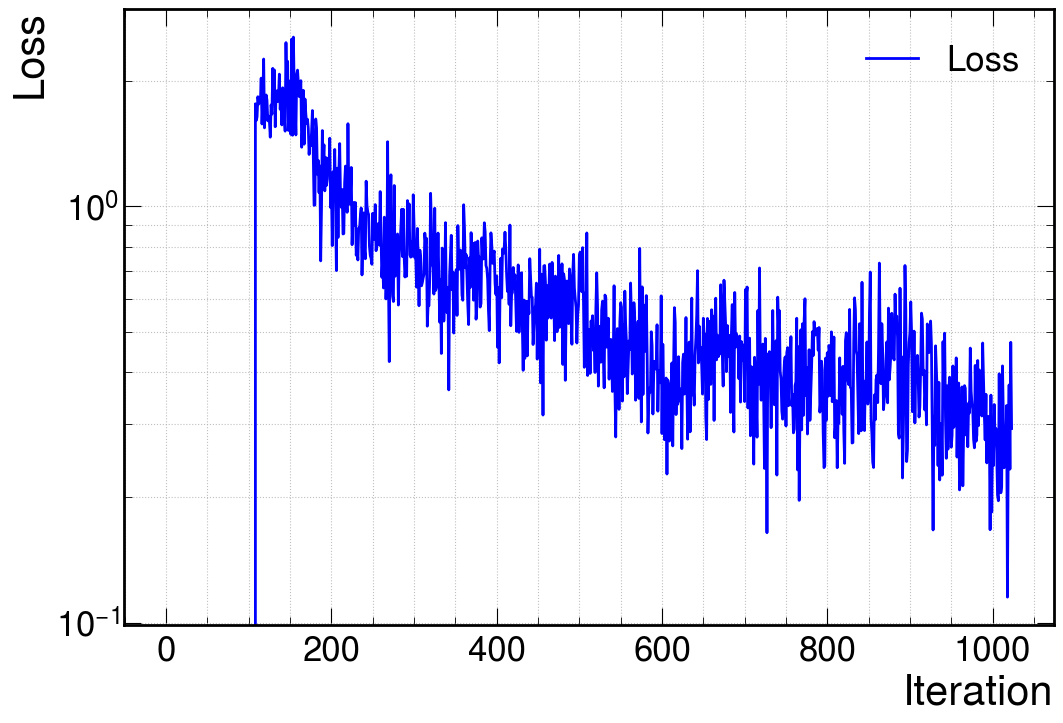

In [378]:
import numpy as np
import matplotlib.pyplot as plt


import mplhep as hep
hep.style.use("CMS")


plt.rcParams.update({
    "text.usetex": False, # LaTeX not available in cytools env
    # "font.family": "Helvetica",
    'font.size': 30
})


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(loss_vals, 'b-', label="Loss", linewidth=2)
# ax.set_xlim([195, len(loss_vals)])
ax.set_yscale('log')

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax.grid(True, 'both')
ax.legend()
# plt.savefig("loss.pdf", bbox_inches='tight')

In [383]:
state = flatten_state(f_env.random_state())
# state = np.asarray([0,3])

num_steps = 0

path = [state]

done = False
while not done:
    action = agent.act(state)
    new_state = f_env.act(restore_state(state), actions[action])
    fitness, done = f_env.R(new_state)

    state = flatten_state(new_state)

    num_steps += 1
    path.append(state)

In [384]:
num_steps

3

In [386]:
f_env.R(restore_state(state))

(2.0, True)